## QA RAG ChatBot using Actuarials Standards of Practice

Using LangChain to build a QA chatbot based on Actuarial Standards of Practice, using persistent memory, LangSmith for model monitoring and logging.

Install relevant packages

In [ ]:
%%capture
!pip install requests
!pip install beautifulsoup4
!pip install PyPDF2
!pip install langchain_community
!pip install langfuse
!pip install tiktoken
!pip install faiss-gpu
!pip install langchain-openai langchain-core langgraph langchain-chroma
!pip install langsmith

Download ASOPs 1 through 57 as well as additional information, such as definitions, procedures for use, and clarifications for specific cases.

In [ ]:
import requests
from bs4 import BeautifulSoup
import os

# Create a directory to store the PDFs
os.makedirs('asop_pdfs', exist_ok=True)

# URLs of the pages to scrape
urls_to_scrape = [
    'http://www.actuarialstandardsboard.org/standards-of-practice/',
    'http://www.actuarialstandardsboard.org/other-documents/'
]

# Set to store unique PDF links
pdf_links = set()

for page_url in urls_to_scrape:
    print(f'Scraping page: {page_url}')
    # Get the page content
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all links to PDFs on the page
    for link in soup.find_all('a', href=True):
        href = link['href']
        if href.endswith('.pdf'):
            # Complete the URL if it's relative
            if href.startswith('/'):
                href = f'http://www.actuarialstandardsboard.org{href}'
            # Add to the set to ensure uniqueness
            pdf_links.add(href)

print(f'Found {len(pdf_links)} unique PDF links.')

# Download each PDF
for url in pdf_links:
    pdf_name = url.split('/')[-1]
    pdf_path = os.path.join('asop_pdfs', pdf_name)
    if not os.path.exists(pdf_path):
        print(f'Downloading {pdf_name}...')
        pdf_response = requests.get(url)
        with open(pdf_path, 'wb') as f:
            f.write(pdf_response.content)
    else:
        print(f'{pdf_name} already exists. Skipping download.')

print('All PDFs downloaded.')


Scraping page: http://www.actuarialstandardsboard.org/standards-of-practice/
Scraping page: http://www.actuarialstandardsboard.org/other-documents/
Found 70 unique PDF links.
All PDFs downloaded.


Extract information from the pdf files

In [ ]:
import PyPDF2

# Create a directory to store the text files
os.makedirs('asop_texts', exist_ok=True)

pdf_folder = 'asop_pdfs'

# Get list of all PDF files downloaded
pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]

for pdf_file in pdf_files:
    pdf_path = os.path.join(pdf_folder, pdf_file)
    text_output_path = os.path.join('asop_texts', pdf_file.replace('.pdf', '.txt'))
    # Skip if text file already exists
    if os.path.exists(text_output_path):
        print(f'Text for {pdf_file} already extracted. Skipping.')
        continue
    print(f'Extracting text from {pdf_file}...')
    try:
        with open(pdf_path, 'rb') as f:
            reader = PyPDF2.PdfReader(f)
            text = ''
            for page_num in range(len(reader.pages)):
                page = reader.pages[page_num]
                page_text = page.extract_text()
                if page_text:
                    text += page_text
        # Save the extracted text to a file
        with open(text_output_path, 'w', encoding='utf-8') as text_file:
            text_file.write(text)
    except Exception as e:
        print(f'Error extracting text from {pdf_file}: {e}')

print('Text extraction completed.')


Extracting text from asop027_197.pdf...
Extracting text from asop022_203.pdf...
Extracting text from asop047_169.pdf...
Extracting text from asop013_133.pdf...
Extracting text from asop031_115.pdf...
Extracting text from asop028_214.pdf...
Extracting text from asop032_196.pdf...
Extracting text from PensionTaskForceReport.pdf...
Extracting text from asop055_194.pdf...
Extracting text from asop044_160.pdf...
Extracting text from Actuarial-Standards-Setting-Process.pdf...
Extracting text from opinions3and4_088.pdf...
Extracting text from asop040_212-1.pdf...
Extracting text from asop007_128.pdf...
Extracting text from asop010_207.pdf...
Extracting text from asop014_082.pdf...
Extracting text from New-ASB-Definitions-updated-10-7-2024.pdf...
Extracting text from asop030_148.pdf...
Extracting text from asop002_204-2.pdf...
Extracting text from asop057_208.pdf...
Extracting text from asop006_177-3.pdf...
Extracting text from financial_067.pdf...
Extracting text from asop052_189.pdf...
Extra

Load the extracted texts

In [ ]:
import os

# Directory containing the extracted text files
text_dir = 'asop_texts'

# List all text files
text_files = [f for f in os.listdir(text_dir) if f.endswith('.txt')]

# Initialize a list to hold all documents
documents = []

for file_name in text_files:
    file_path = os.path.join(text_dir, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
        documents.append(text)


Clean each document

In [ ]:
import re

def clean_text(text):
    # Remove headers and footers (customize patterns as needed)
    text = re.sub(r'ASOP No\.\s*\d+\s*-.*?\n', '', text)  # Remove ASOP headers
    text = re.sub(r'Actuarial Standards Board.*?\n', '', text)  # Remove footer
    text = re.sub(r'Page\s*\d+\s*of\s*\d+', '', text)  # Remove page numbers

    # Remove multiple newlines and excessive whitespace
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'[ \t]+', ' ', text)

    # Strip leading and trailing whitespace
    text = text.strip()

    return text


In [ ]:
cleaned_documents = [clean_text(doc) for doc in documents]


In [ ]:
cleaned_documents[4][0:1000]

'Actuarial Standard \n of Practice \nNo. 12 \n \n \nRisk Classification (fo r All Practice Areas) \n \n \nRevised Edition \n \n \n \nDeveloped by the \nTask Force to Revise ASOP No. 12 of the \nGeneral Committee of the \n \n \nAdopted by the \nDecember 2005 \nUpdated for Deviation Language Effective May 1, 2011 \n \n(Doc. No. 132)ASOP No. 12—December 2005 \n \n iiT A B L E O F C O N T E N T S \n \nTransmittal Memorandum iv \nSTANDARD OF PRACTICE \n \nSection 1. Purpose, Scope, Cross References, and Effective Date 1 \n1.1 Purpose 1 1.2 Scope 1 \n1.3 Cross References 1 1.4 Effective Date 2 \n \nSection 2. Definitions 2 \n2.1 Advice 2 2.2 Adverse Selection 2 2.3 Credibility 2 2.4 Financial or Personal Security System 2 2.5 Homogeneity 2 2.6 Practical 2 2.7 Risk(s) 2 2.8 Risk Characteristics 2 2.9 Risk Class 2 2.10 Risk Classification System 3 \n \nSection 3. Analysis of Issues and Recommended Practices 3 \n3.1 Introduction 3 3.2 Considerations in the Selec tion of Risk Characteristics 3 \

Set up the environment with OpenAI, LangChain, and LangSmith

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

In [ ]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

from langchain_chroma import Chroma
persist_directory = 'chroma_db'

# Initialize the Chroma vector store with the persist_directory
vector_store = Chroma(embedding_function=embeddings, persist_directory=persist_directory)

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGSMITH_API')
os.environ["LANGCHAIN_PROJECT"] = f"langchain-test"


In [ ]:
from langsmith import Client
import getpass

api_key = getpass.getpass('Enter your LangSmith API key: ')
client = Client(api_key=api_key)


Enter your LangSmith API key: ··········


In [ ]:

try:
    projects = client.list_projects()
    print("API Key is valid. Available projects:")
    for project in projects:
        print(project.name)
except Exception as e:
    print(f"Error: {e}")


API Key is valid. Available projects:
default
langchain-test


Split the documents into chunks

In [ ]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

class LangChainDocument(TypedDict):
    page_content: str
    metadata: dict

langchain_docs = [Document(page_content=doc) for doc in cleaned_documents]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(langchain_docs)


Store the chunks in a vector store

In [ ]:

_ = vector_store.add_documents(documents=all_splits)
# Persist the vector store to disk

AttributeError: 'Chroma' object has no attribute 'persist'

Use LangGraph to turn the retriver into a tool

In [ ]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [ ]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [ ]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


tools = ToolNode([retrieve])


def generate(state: MessagesState):
    """Generate answer."""
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an expert in actuarial science with in-depth knowledge of the Actuarial Standards of Practice (ASOPs)."
        "Use the following pieces of retrieved context to answer "
        "If you don't know the answer, say that you "
        "don't know. Please provide a clear and concise answer to the following question."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [ ]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

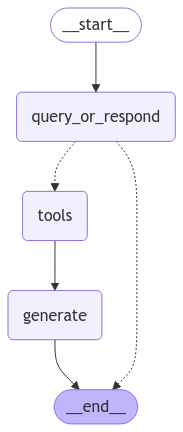

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Create an object to store persistent memory

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

Test!

In [ ]:
input_message = "What are the disclosure requirements under ASOP No. 41?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are the disclosure requirements under ASOP No. 41?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_1jLU2jiv1mGLgBLH21sY5cdI)
 Call ID: call_1jLU2jiv1mGLgBLH21sY5cdI
  Args:
    query: disclosure requirements under ASOP No. 41
================================= Tool Message =================================
Name: retrieve

Source: {}
Content: on the professional judgment of the actuary and may vary with the complexity and purpose 
of the actuarial services. In addition, the actuary should refer to ASOP No. 41 for guidance 
related to the retention of file material other than that which is to be disclosed under section 
4. 
 
Section 4. Communications and Disclosures 
 
4.1 Required Disclosures in an Actuarial Report —When issuing an actuarial report to which 
this standard applies, the actuary should refer to ASOP Nos . 23 and 41. In additio

In [ ]:
input_message = "Do you remember which ASOP I just asked about?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config = config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember which ASOP I just asked about?
================================== Ai Message ==================================

Yes, you asked about the disclosure requirements under ASOP No. 41.
